### Priority
* First, analyze and get the statistics for each df_cell
* Determine whether keep going with unit x state manner
* Attention is related to grasp the important pattern?
* Short chromosome can be mixed up in the sample?
* Prepare all the prerequisites before we enter the pretrain step

In [1]:
from platform import python_version
python_version()

'3.8.8'

In [2]:
import pandas as pd
import json
import tqdm

In [3]:
import pickle

In [4]:
from css_utility import path, bed_files,state_col_dict
from css_utility import state_dict,css_name,css_dict,css_color_dict
from css_utility import file_list_maker,colors2color_dec,bed2df_as_is
from css_utility import bed2df_expanded,total_df_maker,numchr,df2css_allchr
from css_utility import df2chr_index,df2css_chr,df2css_chr_str,css_list2count

In [5]:
import tensorflow as tf

In [6]:
state_col_dict

{'A': (0.8588235294117647, 0.2235294117647059, 0.19607843137254902),
 'B': (0.8705882352941177, 0.3411764705882353, 0.21176470588235294),
 'C': (0.4196078431372549, 0.7333333333333333, 0.3411764705882353),
 'D': (0.2235294117647059, 0.48627450980392156, 0.2823529411764706),
 'E': (0.18823529411764706, 0.3843137254901961, 0.22745098039215686),
 'F': (0.7725490196078432, 0.8352941176470589, 0.3137254901960784),
 'G': (0.9607843137254902, 0.7686274509803922, 0.3843137254901961),
 'H': (0.5058823529411764, 0.7607843137254902, 0.6627450980392157),
 'I': (0.5372549019607843, 0.5607843137254902, 0.7411764705882353),
 'J': (0.7529411764705882, 0.3843137254901961, 0.37254901960784315),
 'K': (0.8745098039215686, 0.611764705882353, 0.4980392156862745),
 'L': (0.7372549019607844, 0.7137254901960784, 0.45098039215686275),
 'M': (0.5764705882352941, 0.5843137254901961, 0.6),
 'N': (0.7843137254901961, 0.792156862745098, 0.796078431372549),
 'O': (1.0, 1.0, 1.0)}

#### Transform into Dataframe from bed file

In [7]:
all_files=file_list_maker(path, bed_files)

In [8]:
test_file_bed=all_files[0]
test_file_bed

'../database/bed/unzipped/E001_15_coreMarks_stateno.bed'

In [9]:
df_test1=bed2df_as_is(test_file_bed)
df_test1.head()

,chromosome,start,end,state
0,chr1,0,9800,15
1,chr1,9800,10600,9
2,chr1,10600,540400,15
3,chr1,540400,540800,1
4,chr1,540800,569800,15


In [10]:
df_test1ex=bed2df_expanded(test_file_bed)
df_test1ex.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,9800,10600,9,800,8,I,IIIIIIII
2,chr1,10600,540400,15,529800,5298,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,4,A,AAAA
4,chr1,540800,569800,15,29000,290,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


#### Read pickled file (unpickling)

In [11]:
df=pd.read_pickle("../database/cell_pickle/df_cell001.pkl")
df.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,9800,10600,9,800,8,I,IIIIIIII
2,chr1,10600,540400,15,529800,5298,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,4,A,AAAA
4,chr1,540800,569800,15,29000,290,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


#### State initial and normalized RGB
*colors2color_dec*

In [12]:
state_col_dict

{'A': (0.8588235294117647, 0.2235294117647059, 0.19607843137254902),
 'B': (0.8705882352941177, 0.3411764705882353, 0.21176470588235294),
 'C': (0.4196078431372549, 0.7333333333333333, 0.3411764705882353),
 'D': (0.2235294117647059, 0.48627450980392156, 0.2823529411764706),
 'E': (0.18823529411764706, 0.3843137254901961, 0.22745098039215686),
 'F': (0.7725490196078432, 0.8352941176470589, 0.3137254901960784),
 'G': (0.9607843137254902, 0.7686274509803922, 0.3843137254901961),
 'H': (0.5058823529411764, 0.7607843137254902, 0.6627450980392157),
 'I': (0.5372549019607843, 0.5607843137254902, 0.7411764705882353),
 'J': (0.7529411764705882, 0.3843137254901961, 0.37254901960784315),
 'K': (0.8745098039215686, 0.611764705882353, 0.4980392156862745),
 'L': (0.7372549019607844, 0.7137254901960784, 0.45098039215686275),
 'M': (0.5764705882352941, 0.5843137254901961, 0.6),
 'N': (0.7843137254901961, 0.792156862745098, 0.796078431372549),
 'O': (1.0, 1.0, 1.0)}

#### Number of chromosome
*numchr*

In [13]:
num_chromosome=numchr(df)
num_chromosome

25

#### Create a large piece of string of the whole state_seq_full in a cell
*df2css_allchar*

In [14]:
all_chr_css=df2css_allchr(df)
all_chr_css[10000:10200]

'MMMMMMMMMMMMKKMMMMMMMMMMMMMMMMMMMMMMMMJJJJJJJJJJJJMMMMMMMMLLLLMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMNNNNNNNNNNNNNNNNNNNNJJJJJJAAAAAAOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'

In [30]:
## save it as a file
with open("test_css2txt.txt","w") as ws:
    ws.write(all_chr_css)

#### Create CSS chromosome-wise
* *df2char_index* : the index (row no.) where each chromosome ends <br>
* *df2css_chr* : create a list of **dataframes**, each of which contains chromosome names and state_seq_full <br>
* *df2css_chr_str* : create a list of **strings** of state_seq_full, all connected per chromosome

In [15]:
chr_index=df2chr_index(df)
chr_index

[45243,
 84706,
 118779,
 146272,
 175237,
 204827,
 231085,
 254353,
 275223,
 298155,
 323185,
 348498,
 362434,
 378184,
 393196,
 408978,
 431073,
 442950,
 459355,
 471900,
 477268,
 486157,
 486165,
 509936,
 510149]

In [16]:
df_chr_list=df2css_chr(df)

In [17]:
df_chr_list[2].head()

,chromosome,state_seq_full
84707,chr3,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
84708,chr3,GGGG
84709,chr3,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...
84710,chr3,GGGGGGGGGGGGGG
84711,chr3,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [18]:
chr_css_list=df2css_chr_str(df)

In [19]:
chr_css_list[2][1000:1200]

'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOGGGGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEGGGGGGGGGGGGGGOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'

#### CSS Pattern analysis
*css_list2count* 
* input: df, chr_css_list
* output; count_all (a dataframe where row=states, column=chromosomes)

In [20]:
count_all=css_list2count(df, chr_css_list)

In [23]:
count_all

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrM,chrX,chrY
A,29630,21000,18162,13428,15666,20234,15376,11350,11672,12044,...,11660,14596,5258,20840,7282,3020,5706,0,13860,44
B,8286,5596,5070,3576,4214,4918,3694,3162,3076,3298,...,2540,4842,1544,2798,2178,730,1596,0,3744,0
C,1092,410,578,426,588,712,392,328,332,240,...,164,486,128,354,302,64,94,0,476,4
D,48450,28844,24862,13432,21428,17066,18322,14210,17464,18234,...,20024,34246,5556,19834,14288,5330,11592,0,10668,6
E,401910,350518,312084,223202,241968,248700,237870,179962,186804,187476,...,148230,186618,97808,142212,111134,43898,90434,0,171668,290
F,2872,1598,1892,1194,1782,1476,1450,1416,1178,1522,...,730,2074,456,912,1044,314,600,0,1016,0
G,105692,93098,86782,63048,70438,72130,58276,54310,48378,52250,...,32706,44466,30376,17742,26694,11236,19116,0,52596,0
H,4558,4890,3684,4278,3860,3720,4912,3222,3022,4744,...,3432,2190,1232,10128,1328,1678,790,2,4726,2188
I,54650,65612,54810,59348,55184,46736,46958,44752,27308,36088,...,17968,20010,19642,35424,11958,11804,6264,58,61612,1462
J,11378,9264,6042,5692,6302,7318,5884,5558,5294,6544,...,4090,7662,2744,6398,3448,1266,2264,0,3786,26


In [28]:
count_all.sum().sum()  # total number of css contained in 1 cell sample

30956914

In [22]:
count_all_renamed=count_all.rename(index=css_dict)

In [53]:
count_all_renamed

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrM,chrX,chrY
TssA,29630,21000,18162,13428,15666,20234,15376,11350,11672,12044,...,11660,14596,5258,20840,7282,3020,5706,0,13860,44
TssAFlnk,8286,5596,5070,3576,4214,4918,3694,3162,3076,3298,...,2540,4842,1544,2798,2178,730,1596,0,3744,0
TxFlnk,1092,410,578,426,588,712,392,328,332,240,...,164,486,128,354,302,64,94,0,476,4
Tx,48450,28844,24862,13432,21428,17066,18322,14210,17464,18234,...,20024,34246,5556,19834,14288,5330,11592,0,10668,6
TxWk,401910,350518,312084,223202,241968,248700,237870,179962,186804,187476,...,148230,186618,97808,142212,111134,43898,90434,0,171668,290
EnhG,2872,1598,1892,1194,1782,1476,1450,1416,1178,1522,...,730,2074,456,912,1044,314,600,0,1016,0
Enh,105692,93098,86782,63048,70438,72130,58276,54310,48378,52250,...,32706,44466,30376,17742,26694,11236,19116,0,52596,0
ZNF/Rpts,4558,4890,3684,4278,3860,3720,4912,3222,3022,4744,...,3432,2190,1232,10128,1328,1678,790,2,4726,2188
Het,54650,65612,54810,59348,55184,46736,46958,44752,27308,36088,...,17968,20010,19642,35424,11958,11804,6264,58,61612,1462
TssBiv,11378,9264,6042,5692,6302,7318,5884,5558,5294,6544,...,4090,7662,2744,6398,3448,1266,2264,0,3786,26


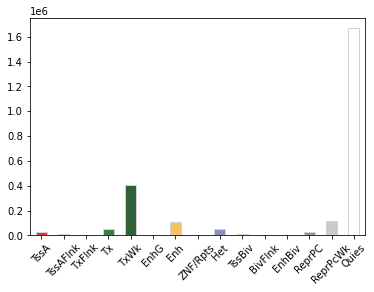

In [55]:
color_dec=colors2color_dec(css_color_dict)
ax0=count_all_renamed.loc[:,"chr1"].plot.bar(rot=45, color=color_dec, edgecolor="lightgray")  # total state

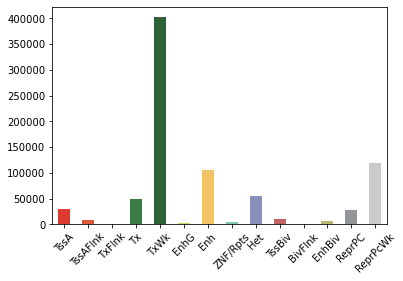

In [56]:
ax1=count_all_renamed.loc[:,"chr1"][:-1].plot.bar(rot=45, color=color_dec)  # except for Quies

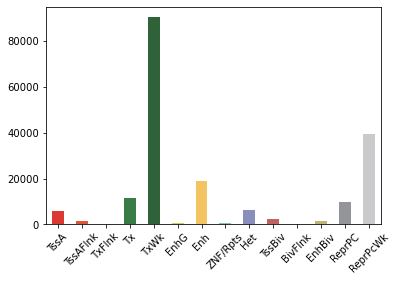

In [68]:
ax1=count_all_renamed.loc[:,"chr22"][:-1].plot.bar(rot=45, color=color_dec)  # except for Quies

In [43]:
# df_test=json.load("./cell_json/df_cell001.json")
# df_test